In [203]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [204]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to D:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to D:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to D:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     D:\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [205]:
stop_words = set(stopwords.words('english'))
domain_words = {
    "airport","klia","staff","malaysia","malaysian","flight","terminal","gate","counter",
    "immigration","airline","airlines","plane","arrival","departure","queue","checkin",
    "baggage","luggage"
}
stop_words.update(domain_words)

In [206]:
lemmatizer = WordNetLemmatizer()

In [207]:
def handle_negation(text):
    # simple negation handling: add "_NEG" to words after negation
    neg_pattern = re.compile(r"\b(not|no|never|n't)\b\s+(\w+)")
    return neg_pattern.sub(lambda m: m.group(1) + ' ' + m.group(2) + '_NEG', text)

In [208]:
def get_pos(tag):
    if tag.startswith('J'): return wordnet.ADJ
    elif tag.startswith('V'): return wordnet.VERB
    elif tag.startswith('N'): return wordnet.NOUN
    elif tag.startswith('R'): return wordnet.ADV
    else: return wordnet.NOUN

def preprocess(text):
    if not isinstance(text, str):
        return ""
    # Handle encoding issues
    text = text.encode('latin1', 'ignore').decode('utf-8', 'ignore')
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower().translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    lemmas = [
        lemmatizer.lemmatize(tok, get_pos(tag))
        for tok, tag in tagged
        if tok not in stop_words
    ]
    return " ".join(lemmas)

In [209]:
df = pd.read_csv("training_data.csv")  # make sure this is your file
df['clean_text'] = df['TEXT'].apply(preprocess)

In [210]:
X = df['clean_text']
y = df['SENTIMENT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [211]:
#TF-IDF Vectorixer

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [212]:
base_svm = LinearSVC(random_state=42)
svm = CalibratedClassifierCV(base_svm)  # enables predict_proba
svm.fit(X_train_tfidf, y_train)

,estimator,LinearSVC(random_state=42)
,method,'sigmoid'
,cv,None
,n_jobs,None
,ensemble,'auto'
,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'


In [213]:
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(svm, "svm_model_tuned.pkl")

['svm_model_tuned.pkl']

In [214]:
y_pred = svm.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

    Negative     0.8859    0.9199    0.9026       287
     Neutral     0.9091    0.3030    0.4545        33
    Positive     0.8325    0.8788    0.8550       198

    accuracy                         0.8649       518
   macro avg     0.8758    0.7006    0.7374       518
weighted avg     0.8670    0.8649    0.8559       518



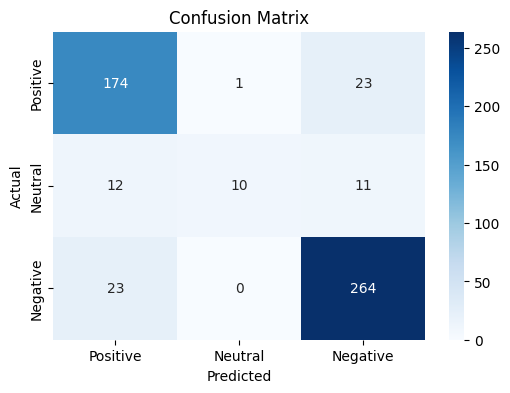

In [215]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred, labels=['Positive','Neutral','Negative'])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Positive','Neutral','Negative'], yticklabels=['Positive','Neutral','Negative'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")
plt.show()

In [216]:
df_unlabeled = pd.read_csv("unlabeled_real_data.csv")
pred_list = []
conf_list = []

for review in df_unlabeled['TEXT']:
    processed = preprocess(review)
    X_review = tfidf.transform([processed])
    pred = svm.predict(X_review)[0]
    conf = svm.predict_proba(X_review).max()
    pred_list.append(pred)
    conf_list.append(f"{conf*100:.2f}%")

df_unlabeled['Predicted_Sentiment'] = pred_list
df_unlabeled['Confidence'] = conf_list
df_unlabeled.to_csv("unlabeled_predictions.csv", index=False)
print("Predictions saved to unlabeled_predictions.csv")

Predictions saved to unlabeled_predictions.csv
